# Predicting Movie Revenue

## Features  

**Variable to Predict:** Revenue


- Budget  
- Runtime  
- Genre  
- Release Date  
 - Season  
 - Holiday   
- Production Companies  
 - Number of companies involved  
 - Number of movies a company has made (previously)  
- Crew
 - Number of crewmembers  
- Cast
 - Gender Ratio for top 2/5/10/25
 - Number of previous movies top 10 cast have been in
- Collection
 - Is sequel (order)  


In [1]:
import numpy as np
import pandas as pd
import sqlite3
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
from scipy import stats

pd.set_option('display.float_format','{:,.2f}'.format)

In [2]:
db = sqlite3.connect(r'../../../Data Science Data/Unit 3/db.sqlite')

In [3]:
## SQL import statements to create dataframes

# Base dataframe to join other onto
base_df = pd.read_sql("""SELECT movie_id, budget, release_date, revenue, runtime, imdb_budget, imdb_revenue, title, collection 
                         FROM movies 
                         WHERE (budget > 0 OR imdb_budget > 0) AND (revenue > 0 OR imdb_revenue > 0)
                      """, db, index_col='movie_id', parse_dates=['release_date'])
base_df.index = base_df.index.map(int)

# Pull in genre table to create dummy variables
genre_df = pd.read_sql("""SELECT * FROM genres""", db)

# Create series for number of production companies associated with each movie_id
number_of_prod_companies = pd.read_sql("""SELECT movie_id, COUNT(company_name) AS prod_company_count
                                          FROM production_companies
                                          GROUP BY movie_id
                                          """, db, index_col='movie_id')
number_of_prod_companies.index = number_of_prod_companies.index.map(int)

production_companies = pd.read_sql("""
    SELECT *
    FROM production_companies
    """, db)
production_companies['movie_id'] = production_companies['movie_id'].map(int)

# Create series for number of crew members associated with each movie_id
number_of_crewmembers = pd.read_sql("""SELECT movie_id, COUNT(crew_member_id) AS crewmember_count
                                       FROM crew
                                       GROUP BY movie_id
                                       """, db, index_col='movie_id')
number_of_crewmembers.index = number_of_crewmembers.index.map(int)

# Dataframe for cast data to create gender ratio, and number of previous movies for cast
cast_data = pd.read_sql("""SELECT cc.movie_id, cc.cast_member_id, cc.cast_order, c.gender, m.release_date
                           FROM cast_credit cc
                           JOIN cast c ON cc.cast_member_id = c.cast_member_id
                           JOIN movies m ON cc.movie_id = m.movie_id
                                  """, db)
cast_data.index = cast_data.index.map(int)

In [4]:
# Create feature to note if the movie is a sequel
base_df.sort_values(['collection', 'release_date'], inplace=True)
base_df['order_in_collection'] = 1

current = None
counter = 1

for index, row in base_df.iterrows():
    if row['collection'] is None:
        break
    if current != row['collection']:
        counter = 1
    base_df.set_value(index,'order_in_collection', counter)
    current = row['collection']
    counter += 1

In [5]:
# Create feature for season
seasons = {
    1:'winter',
    2:'winter',
    3:'spring',
    4:'spring',
    5:'spring',
    6:'summer',
    7:'summer',
    8:'summer',
    9:'fall',
    10:'fall',
    11:'fall',
    12:'winter'
}

def season_for_date(date):
    if pd.notnull(date):
        return seasons[date.month]
    else:
        return None

movie_season = base_df['release_date'].apply(season_for_date)
movie_season.rename('season', inplace=True);

In [6]:
# Create feature for holiday
us_holidays = holidays.UnitedStates()

def check_holiday(date):
    if pd.notnull(date):
        return any((date + timedelta(days=i)) in us_holidays for i in range(-4,5))
    else:
        return None
    
movie_is_holiday = base_df['release_date'].apply(check_holiday)
movie_is_holiday.rename('is_holiday', inplace=True);

In [7]:
# Create feature for production company experience
production_companies_joined = production_companies.merge(base_df, left_on='movie_id', right_index=True, how='left')

production_companies_joined.sort_values(['company_name', 'release_date'], inplace=True)
production_companies_joined['movies_produced'] = 0

current = None
counter = 0

for index, row in production_companies_joined.iterrows():
    if current != row['company_name']:
        counter = 0
    production_companies_joined.set_value(index,'movies_produced', counter)
    current = row['company_name']
    counter += 1
    
production_company_experience = production_companies_joined.groupby(by='movie_id').sum()['movies_produced']

In [8]:
# Create feature for cast experience
cast_data.sort_values(['cast_member_id', 'release_date'], inplace=True)
cast_data['movie_experience'] = 0

current = None
counter = 0

for index, row in cast_data.iterrows():
    if current != row['cast_member_id']:
        counter = 0
    cast_data.set_value(index,'movie_experience', counter)
    current = row['cast_member_id']
    counter += 1
    
cast_experience = cast_data[cast_data['cast_order'] <= 10].groupby('movie_id').sum()['movie_experience']

In [9]:
# Create dummy variables for genre
pivot_genre = genre_df.pivot_table(index='movie_id',columns='genre_name', values='genre_name',aggfunc=len, fill_value=0)
pivot_genre.index = pivot_genre.index.map(int)
pivot_genre = pivot_genre.apply(pd.to_numeric)

In [10]:
# Create column for gender ratio
gender_data = cast_data[cast_data['gender'] != 0]
gender_data = gender_data[gender_data['cast_order'] <= 5]
gender_data['gender'] = gender_data['gender'] - 1
gender_data = gender_data.groupby(by='movie_id').mean()['gender']
gender_data.index = gender_data.index.map(int)

In [11]:
# Join 'em up
df = base_df.join(pivot_genre, how='inner')
df = df.join(number_of_prod_companies, how='inner')
df = df.join(number_of_crewmembers, how='inner')
df = df.join(gender_data, how='inner')
df = df.join(cast_experience, how='inner')
df = df.join(production_company_experience, how='inner')
df = df.join(movie_is_holiday, how='inner')
df = df.join(movie_season, how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6195 entries, 117263 to 394117
Data columns (total 36 columns):
budget                 6195 non-null int64
release_date           6195 non-null datetime64[ns]
revenue                6195 non-null int64
runtime                6188 non-null float64
imdb_budget            1938 non-null object
imdb_revenue           2007 non-null object
title                  6195 non-null object
collection             1254 non-null object
order_in_collection    6195 non-null int64
Action                 6195 non-null int64
Adventure              6195 non-null int64
Animation              6195 non-null int64
Comedy                 6195 non-null int64
Crime                  6195 non-null int64
Documentary            6195 non-null int64
Drama                  6195 non-null int64
Family                 6195 non-null int64
Fantasy                6195 non-null int64
Foreign                6195 non-null int64
History                6195 non-null int64
Horror     

In [12]:
df['complete_budget'] = df['budget'].replace(0,np.nan).fillna(df['imdb_budget'])
df['complete_revenue'] = df['revenue'].replace(0,np.nan).fillna(df['imdb_revenue'])

df['complete_budget'] = pd.to_numeric(df['complete_budget'],errors='coerce',downcast='integer')
df['complete_revenue'] = pd.to_numeric(df['complete_revenue'],errors='coerce',downcast='integer')

df['runtime'] = pd.to_numeric(df['runtime'],downcast='integer')
df['gender'] = pd.to_numeric(df['gender'],downcast='integer')

In [13]:
df['is_sequel'] = df['order_in_collection'] > 1
df['profit'] = df['complete_revenue'] - df['complete_budget']
df['ROI'] = df['profit'] / df['complete_budget']

In [14]:
cols_to_drop = ['budget','revenue','imdb_budget','imdb_revenue','collection','order_in_collection']
df.drop(cols_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)
df.drop(df[df['release_date'].dt.year < 1965].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 117263 to 394117
Data columns (total 35 columns):
release_date          5334 non-null datetime64[ns]
runtime               5334 non-null float64
title                 5334 non-null object
Action                5334 non-null int64
Adventure             5334 non-null int64
Animation             5334 non-null int64
Comedy                5334 non-null int64
Crime                 5334 non-null int64
Documentary           5334 non-null int64
Drama                 5334 non-null int64
Family                5334 non-null int64
Fantasy               5334 non-null int64
Foreign               5334 non-null int64
History               5334 non-null int64
Horror                5334 non-null int64
Music                 5334 non-null int64
Mystery               5334 non-null int64
Romance               5334 non-null int64
Science Fiction       5334 non-null int64
TV Movie              5334 non-null int64
Thriller              5334 non-nul

In [15]:
# Top 10 box office grossing movies
df.sort_values('complete_revenue',ascending=False,inplace=True)
df.head(n=10)

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,gender,movie_experience,movies_produced,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI
movie_id,,,,,,,,,,,,,,,,,,,,,
1362,1977-11-27,77.00,The Hobbit,0,1,1,0,0,0,0,...,1.00,73,13,True,fall,"3,000,000.00","5,000,000,000.00",False,"4,997,000,000.00","1,665.67"
19995,2009-12-10,162.00,Avatar,1,1,0,0,0,0,0,...,0.50,145,604,False,winter,"237,000,000.00","2,787,965,087.00",False,"2,550,965,087.00",10.76
140607,2015-12-15,136.00,Star Wars: The Force Awakens,1,1,0,0,0,0,0,...,0.60,219,40,False,winter,"245,000,000.00","2,068,223,624.00",True,"1,823,223,624.00",7.44
597,1997-11-18,194.00,Titanic,0,0,0,0,0,0,1,...,0.40,154,1108,False,fall,"200,000,000.00","1,845,034,188.00",False,"1,645,034,188.00",8.23
24428,2012-04-25,143.00,The Avengers,1,1,0,0,0,0,0,...,0.83,327,811,False,spring,"220,000,000.00","1,519,557,910.00",False,"1,299,557,910.00",5.91
135397,2015-06-09,124.00,Jurassic World,1,1,0,0,0,0,0,...,1.00,204,205,False,summer,"150,000,000.00","1,513,528,810.00",True,"1,363,528,810.00",9.09
168259,2015-04-01,137.00,Furious 7,1,0,0,0,0,0,0,...,0.80,258,757,False,spring,"190,000,000.00","1,506,249,360.00",True,"1,316,249,360.00",6.93
99861,2015-04-22,141.00,Avengers: Age of Ultron,1,1,0,0,0,0,0,...,0.83,362,43,False,spring,"280,000,000.00","1,405,403,694.00",True,"1,125,403,694.00",4.02
12445,2011-07-07,130.00,Harry Potter and the Deathly Hallows: Part 2,0,1,0,0,0,0,0,...,0.50,296,896,True,summer,"125,000,000.00","1,342,000,000.00",True,"1,217,000,000.00",9.74


In [16]:
# The Hobbit animated movie?? Really? Let's remove... 
df.drop(df[df['title'] == 'The Hobbit'].index, inplace=True)

In [17]:
# Look at the lowest quantile to check for outliers
df[df['complete_revenue'] < df['complete_revenue'].quantile(q=.0075)]

# Notes
# Trojan War: Only released in one theater in the US over one weekend. Not a good representation of what we are trying to predict
# Sunrise: Foreign movie released in theaters in the US 2 years after originally released in France
# Skin Trade: Terrible movie that starred Dolph Lungren. With the exception of Rocky, his movies have been terrible. Something to model in the future?
# Next Time I'll Aim for the Heart: French movie. Grossed 4mil Euros, but did very little in the USA. 

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,gender,movie_experience,movies_produced,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI
movie_id,,,,,,,,,,,,,,,,,,,,,
327833,2014-11-07,96.00,Skin Trade,1,0,0,0,0,0,1,...,0.83,266,2,True,fall,"9,000,000.00","1,242.00",False,"-8,998,758.00",-1.00
328930,2014-10-03,85.00,Sunrise,0,0,0,0,0,0,1,...,1.00,21,15,False,fall,"700,000.00","1,000.00",False,"-699,000.00",-1.00
298459,2014-11-12,111.00,Next Time I'll Aim for the Heart,0,0,0,0,1,0,1,...,0.67,80,52,True,fall,"5,100,000.00",714.00,False,"-5,099,286.00",-1.00
77633,2001-12-21,100.00,Big Shot's Funeral,0,0,0,1,0,0,0,...,0.83,182,346,True,winter,"3,300,000.00",646.00,False,"-3,299,354.00",-1.00
92493,2011-09-10,105.00,Edwin Boyd: Citizen Gangster,0,0,0,0,1,0,1,...,0.83,176,10,False,fall,"5,000,000.00",625.00,False,"-4,999,375.00",-1.00
14330,1997-09-26,85.00,Trojan War,0,0,0,1,0,0,0,...,0.60,19,696,False,fall,"15,000,000.00",217.00,False,"-14,999,783.00",-1.00
57186,2010-10-06,97.00,Skinning,1,0,0,0,1,0,1,...,1.00,80,2,False,fall,"500,000.00",198.00,False,"-499,802.00",-1.00
22717,2009-09-18,129.00,Wanted,1,0,0,1,1,0,0,...,0.80,305,4,False,fall,75.00,134.00,False,59.00,0.79
212769,2013-08-07,110.00,Make Your Move,0,0,0,0,0,0,0,...,0.60,29,37,False,summer,15.00,122.00,False,107.00,7.13


In [18]:
# Remove movies with a budget less than 25,000
df.drop(df[df['complete_budget'] < 500000].index,inplace=True)
df.describe()

,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Western,prod_company_count,crewmember_count,gender,movie_experience,movies_produced,complete_budget,complete_revenue,profit,ROI
count,"5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00",...,"5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00","5,153.00"
mean,110.64,0.28,0.18,0.05,0.37,0.17,0.00,0.48,0.10,0.10,...,0.02,3.00,27.45,0.68,122.05,244.63,"30,905,984.76","82,640,234.67","51,734,249.90",2.25
std,23.15,0.45,0.38,0.21,0.48,0.37,0.07,0.50,0.30,0.30,...,0.13,2.21,31.97,0.22,103.79,292.89,"38,214,415.08","161,284,713.30","136,358,320.57",6.99
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,"500,000.00",1.00,"-165,710,090.00",-1.00
25%,96.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,9.00,0.50,58.00,19.00,"7,000,000.00","5,600,000.00","-4,923,575.00",-0.49
50%,106.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2.00,16.00,0.67,100.00,92.00,"18,000,000.00","24,911,670.00","6,734,992.00",0.58
75%,121.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,4.00,32.00,0.83,156.00,443.00,"40,000,000.00","86,865,564.00","50,997,208.00",2.48
max,422.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,26.00,435.00,1.00,"1,295.00","1,791.00","380,000,000.00","2,787,965,087.00","2,550,965,087.00",179.18


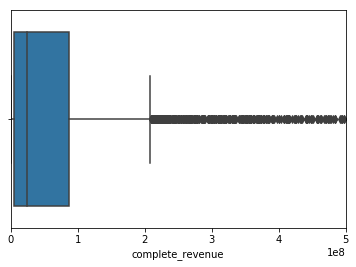

In [19]:
sns.boxplot(x=df['complete_revenue'])
plt.xlim(0,500000000)
plt.show()

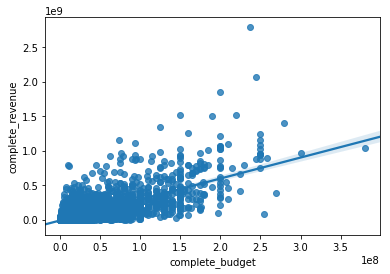

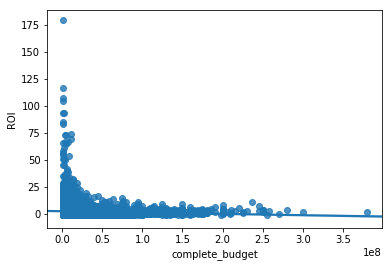

In [20]:
sns.regplot(y=df['complete_revenue'],x=df['complete_budget'])
plt.show() 

sns.regplot(y=df['ROI'],x=df['complete_budget'])
plt.show()

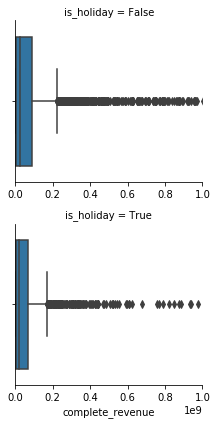

KruskalResult(statistic=8.8397991286523698, pvalue=0.0029473158272534544)

In [21]:
g = sns.FacetGrid(df[['is_holiday','complete_revenue','complete_budget']],row='is_holiday')
g.map(sns.boxplot, 'complete_revenue')
plt.xlim(0,1000000000)
plt.show()

stats.kruskal(df[df['is_holiday'] == True]['complete_revenue'], df[df['is_holiday'] == False]['complete_revenue'])

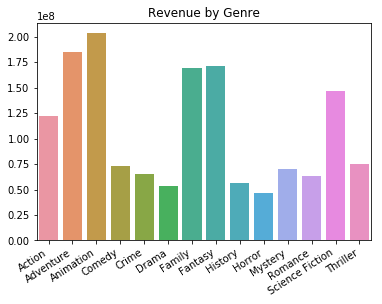

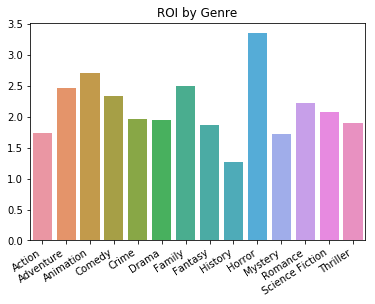

In [22]:
genre_list = list(genre_df.groupby('genre_name').count().index)

genre_count = {}

for genre in genre_list:
    genre_count[genre] = df[df[genre] == 1]['complete_revenue'].count()

genre_list = [key for key,values in genre_count.items() if values > 200]

genre_mean = {}
genre_ROI = {}

for genre in genre_list:
    genre_mean[genre] = df[df[genre] == 1]['complete_revenue'].mean()
    genre_ROI[genre] = df[df[genre] == 1]['ROI'].mean()
    
sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_mean.values()])
plt.title('Revenue by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_ROI.values()])
plt.title('ROI by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

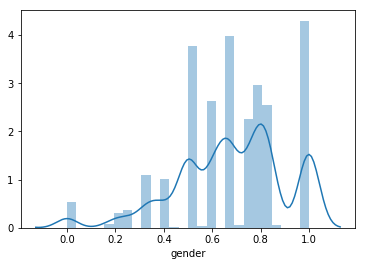

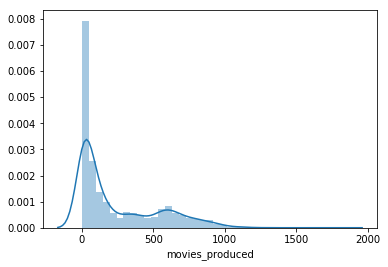

In [23]:
sns.distplot(df['gender'])
plt.show()

sns.distplot(df['movies_produced'])
plt.show()

In [24]:
# cols = ['runtime','prod_company_count','crewmember_count','gender','movie_experience','movies_produced','complete_budget','complete_revenue']

# g = sns.PairGrid(df[cols], diag_sharey=False)
# g.map_upper(plt.scatter)
# g.map_lower(sns.regplot) # scatter_kws=dict(alpha=0))
# g.map_diag(sns.kdeplot)

# plt.show()

In [25]:
df.corr()[['complete_revenue','complete_budget','ROI']]

,complete_revenue,complete_budget,ROI
runtime,0.17,0.17,0.02
Action,0.15,0.25,-0.05
Adventure,0.30,0.36,0.01
Animation,0.17,0.17,0.01
Comedy,-0.04,-0.07,0.01
Crime,-0.05,-0.04,-0.02
Documentary,-0.02,-0.04,0.06
Drama,-0.18,-0.20,-0.04
Family,0.18,0.19,0.01
Fantasy,0.19,0.23,-0.02


In [26]:
df.drop(['profit','ROI','release_date','title'],axis=1,inplace=True)

df_dum = pd.get_dummies(df)

x = df_dum.loc[:,df.columns != 'complete_revenue']
y = df_dum['complete_revenue']

df_dum.columns

Index(['runtime', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'prod_company_count', 'crewmember_count',
       'gender', 'movie_experience', 'movies_produced', 'complete_budget',
       'complete_revenue', 'is_sequel', 'is_holiday_False', 'is_holiday_True',
       'season_fall', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

dt = DecisionTreeRegressor()

cross_val_score(dt, x, y=y, cv=5)

array([-0.59874305,  0.0772542 ,  0.03274033,  0.0916112 , -6.28362205])